In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textwrap
import os
import matplotlib.patches as patches
import matplotlib.colors as mcolors

# Ensure the output directory exists
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# =============================================================================
# Helper Functions
# =============================================================================
def load_data(filepath: str) -> pd.DataFrame:
    """Load the CSV file with a pipe delimiter."""
    return pd.read_csv(filepath, delimiter="|")


def plot_comparison(observed, expected, title, chart_type="bar", save_fig = False):
    """
    Plot a comparison between observed and expected distributions.
    Chart types supported: 'bar' (default) and 'line'.
    """
    categories = list(expected.keys())
    obs_vals = np.array([observed.get(cat, 0) for cat in categories])
    exp_vals = np.array([expected[cat] for cat in categories])
    print(obs_vals)
    print(exp_vals)

    
            
    sample_size = 1000
    standard_devs = []
    for i in exp_vals:
        print(i)
        variance = (sample_size * i)*(1-i)
        print("var:", variance)
        standard_dev = np.sqrt(variance)
        print("std:", standard_dev)
        standard_dev = standard_dev/1000
        standard_devs.append(standard_dev)

    print(standard_devs)
    
        

    x=np.arange(len(categories))
    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.35

    if chart_type == "bar":
        
        rects1 = ax.bar(x - width / 2, obs_vals, width, label='Observed', color='blue', yerr=standard_devs, capsize=5)
        rects2 = ax.bar(x + width / 2, exp_vals, width, label='Expected', color='#DC3220')
        for rect in rects1 + rects2:
            height = rect.get_height()

    wrapped_labels = [textwrap.fill(label, width=13) for label in categories]

    font_size = 16
    # ax.tick_params(axis='y', labelsize=font_size)
    ax.set_ylabel('Fraction', fontsize=font_size)
    ax.set_title(title, fontsize=font_size+2)
    ax.set_xticks(x)
    ax.set_xticklabels(wrapped_labels, fontsize=font_size, rotation=90)
    ax.legend(fontsize=font_size)
    plt.tight_layout()

    # Save the figure as PNG
    if save_fig:
        filename = f"{output_dir}/{title.replace(' ', '_').lower()}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        print(f"Saved: {filename}")
        
    plt.show()


def compute_expected_disability(row):
    """
    Compute the expected disability probabilities for each disability type.
    For each patient, we first compute the probability of being disabled based on
    age and sex, and then distribute that probability among the 10 disability types.
    This returns a Series where each value is the expected contribution for that disability.
    """
    # Determine sex and age index
    sex = row.get("Sex", "Male")
    age = row.get("Age", 30)
    sex_idx = 0 if sex == "Male" else 1
    if age < 25:
        age_idx = 0
    elif age < 65:
        age_idx = 1
    else:
        age_idx = 2

    # Compute the probability of being disabled based on hard-coded matrices
    if sex_idx == 0:  # Male
        disability_probability_total = [0.158, 0.211, 0.389]
    else:  # Female
        disability_probability_total = [0.247, 0.269, 0.418]
    
    p_disabled = disability_probability_total[age_idx]

    # Normalize the distribution for the 10 disability types
    s = 38.6 + 61.8 + 27.4 + 20.7 + 18.2 + 39.2 + 40.3 + 20.7 + 18.4 + 5.7
    
    disability_probability_types = [38.6/s, 61.8/s,
                                   27.4/s, 20.7/s,
                                   18.2/s, 39.2/s,
                                   40.3/s, 20.7/s,
                                   18.4/s, 5.7/s]
    
    disability_categories = [
        "Mental-health related", "Pain-related", "Seeing", 
        "Learning", "Memory", "Mobility", "Flexibility", 
        "Hearing", "Dexterity", "Developmental"
    ]
    
    # Each disability category’s expected probability is:
    # p(disabled) * (normalized probability for that type)
    expected = {cat: p_disabled * prob for cat, prob in zip(disability_categories, disability_probability_types)}
    return pd.Series(expected)

def assign_age_group(age):
    """
    Assign a simplified age group for certain analyses.
    For education analysis: '18-25', '25-64', '65+'.
    """
    if age < 25:
        return '18-25'
    elif age < 65:
        return '25-64'
    else:
        return '65+'


def assign_age_group_extended(age):
    """
    Assign an extended age group for demographic comparisons.
    Groups: '18-25', '26-35', '36-45', '46-60', '60+'.
    """
    if age < 25:
        return '18-25'
    elif age < 36:
        return '26-35'
    elif age < 46:
        return '36-45'
    elif age < 61:
        return '46-60'
    else:
        return '60+'

def plot_children_heatmaps(df, save_fig=False):
    """
    Combines the observed and expected fraction with children by age group and gender into one plot.
    Each cell is split diagonally:
      - Upper-left triangle: observed fraction (Blues)
      - Lower-right triangle: expected fraction (Reds)
    Both values are formatted as decimals with two-digit precision.
    Two separate colorbars are added on the right using dedicated axes with enough spacing.
    """
    # ----------------------------
    # Define demographic model arrays:
    # ----------------------------
    in_family = [  # women, men
        [0.0756, 0.0701],  # 0-24
        [0.5102, 0.4765],  # 25-34
        [0.8340, 0.8178],  # 35-44
        [0.8426, 0.8557],  # 45-54
    ]
    w_children = [  # yes, no
        [0.6997, 0.3003],  # 0-24
        [0.5193, 0.4807],  # 25-34
        [0.2056, 0.7944],  # 35-44
        [0.1771, 0.8229],  # 45-54
    ]
    
    # ----------------------------
    # Prepare age groups and data subset:
    # ----------------------------
    age_bins = [0, 25, 35, 45, 55]
    age_labels = ['0-24', '25-34', '35-44', '45-54']
    
    df = df.copy()
    df = df[df['Age'] < 55]
    df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)
    df['Sex'] = df['Sex'].str.capitalize()  # Ensure consistent gender labeling
    df['Has_Children'] = df['Children'].fillna(0).astype(int).apply(lambda x: "Yes" if x > 0 else "No")
    
    # ----------------------------
    # Compute Observed Fraction with Children:
    # ----------------------------
    observed = (
        df.groupby(['Age_Group', 'Sex'])['Has_Children']
          .value_counts(normalize=True)
          .unstack()
          .fillna(0)
    )
    # We only need the "Yes" column.
    observed_df = observed[['Yes']].reset_index().pivot(index="Age_Group", columns="Sex", values="Yes")
    
    # ----------------------------
    # Compute Expected Fraction with Children:
    # ----------------------------
    expected = {}
    for idx, label in enumerate(age_labels):
        # For females:
        expected[(label, 'Female')] = in_family[idx][0] * w_children[idx][0]
        # For males:
        expected[(label, 'Male')] = in_family[idx][1] * w_children[idx][0]
    expected_series = pd.Series(expected)
    expected_df = expected_series.unstack()
    
    # ----------------------------
    # Determine common color scale limits:
    # ----------------------------
    max_val = max(observed_df.max().max(), expected_df.max().max())
    
    # ----------------------------
    # Combined Diagonal Heatmap Plot:
    # ----------------------------
    age_groups = observed_df.index.tolist()
    sexes = observed_df.columns.tolist()
    observed_arr = observed_df.values  # shape: (n_age, n_sex)
    expected_arr = expected_df.loc[age_groups, sexes].values
    
    n_rows, n_cols = observed_arr.shape

    cmap_obs = plt.get_cmap("Blues")
    cmap_exp = plt.get_cmap("Reds")
    norm_obs = mcolors.Normalize(vmin=0, vmax=max_val)
    norm_exp = mcolors.Normalize(vmin=0, vmax=max_val)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set_xlim(0, n_cols)
    ax.set_ylim(0, n_rows)
    ax.invert_yaxis()  # so that row 0 is at the top

    ax.set_xticks(np.arange(n_cols) + 0.5)
    ax.set_yticks(np.arange(n_rows) + 0.5)
    ax.set_xticklabels(sexes, fontsize=11)
    ax.set_yticklabels(age_groups, fontsize=11)
    
    # Draw the split cells.
    for i in range(n_rows):
        for j in range(n_cols):
            tl = (j, i)       # top-left
            bl = (j, i+1)     # bottom-left
            br = (j+1, i+1)   # bottom-right
            tr = (j+1, i)     # top-right
            
            # Upper-left (observed)
            obs_val = observed_arr[i, j]
            color_obs = cmap_obs(norm_obs(obs_val))
            triangle_obs = patches.Polygon([tl, bl, tr], facecolor=color_obs, edgecolor="white")
            ax.add_patch(triangle_obs)
            
            # Lower-right (expected)
            exp_val = expected_arr[i, j]
            color_exp = cmap_exp(norm_exp(exp_val))
            triangle_exp = patches.Polygon([bl, br, tr], facecolor=color_exp, edgecolor="white")
            ax.add_patch(triangle_exp)
            
            # Annotations for each triangle.
            ax.text(j + 0.3, i + 0.3, f"{obs_val:.2f}",
                    ha="center", va="center", fontsize=9, color="black")
            ax.text(j + 0.7, i + 0.7, f"{exp_val:.2f}",
                    ha="center", va="center", fontsize=9, color="black")
    
    ax.set_title("Combined Fraction with Children by Age and Gender\n(Upper-left: Observed | Lower-right: Expected)", fontsize=14)
    ax.set_xlabel("Sex", fontsize=12)
    ax.set_ylabel("Age Group", fontsize=12)
    
    # ----------------------------
    # Adjust layout and add separate colorbars:
    # ----------------------------
    # Shrink the main plot to leave more space on the right.
    plt.subplots_adjust(right=0.60)
    
    # Create separate colorbar axes with extra horizontal separation.
    # Observed colorbar axis
    cbar_obs_ax = fig.add_axes([0.65, 0.15, 0.02, 0.7])
    sm_obs = plt.cm.ScalarMappable(cmap=cmap_obs, norm=norm_obs)
    sm_obs.set_array([])
    cbar_obs = fig.colorbar(sm_obs, cax=cbar_obs_ax)
    cbar_obs.set_label("Observed Fraction", fontsize=12)
    
    # Expected colorbar axis, placed farther to the right.
    cbar_exp_ax = fig.add_axes([0.78, 0.15, 0.02, 0.7])
    sm_exp = plt.cm.ScalarMappable(cmap=cmap_exp, norm=norm_exp)
    sm_exp.set_array([])
    cbar_exp = fig.colorbar(sm_exp, cax=cbar_exp_ax)
    cbar_exp.set_label("Expected Fraction", fontsize=12)
    
    if save_fig:
        filename = "plots/combined_children_by_age_gender.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        print(f"Saved: {filename}")
    
    plt.show()



/tmp/ipykernel_929265/2464399638.py:197: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['Age_Group', 'Sex'])['Has_Children']


Saved: plots/combined_children_by_age_gender.png


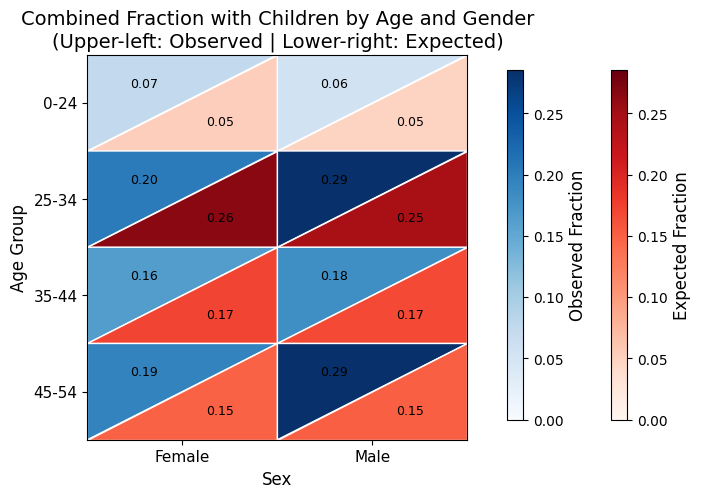

[0.05217391 0.10434783 0.03913043 0.00869565 0.00869565 0.02173913
 0.04347826 0.05217391 0.00869565 0.        ]
[0.03366902 0.05390532 0.02389977 0.01805566 0.01587503 0.03419237
 0.03515185 0.01805566 0.01604948 0.00497185]
0.03366901580755999
var: 32.53541318211026
std: 5.703982221405521
0.0539053154639177
var: 50.99953242865321
std: 7.141395691925578
0.02389976769759463
var: 23.328568801595644
std: 4.829965714329207
0.018055663917525742
var: 17.7296569180231
std: 4.2106599147904475
0.015875028178694184
var: 15.62301165901985
std: 3.952595559758151
0.034192368384879955
var: 33.02325032911262
std: 5.746585971610676
0.035151848109965855
var: 33.91619568441975
std: 5.823761300432887
0.018055663917525742
var: 17.7296569180231
std: 4.2106599147904475
0.01604947903780086
var: 15.791893260416051
std: 3.9739015161948905
0.004971849484536087
var: 4.947130197239206
std: 2.2242145124153843
[np.float64(0.005703982221405521), np.float64(0.0071413956919255785), np.float64(0.004829965714329207), n

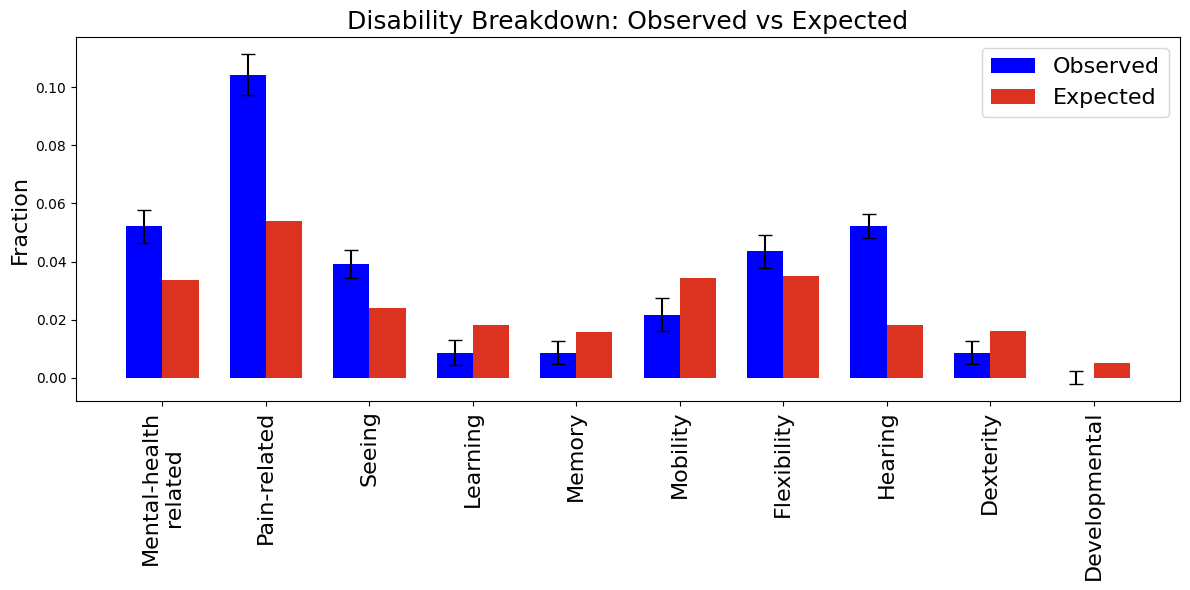

[0.482 0.518]
[0.49 0.51]
0.49
var: 249.9
std: 15.8082257068907
0.51
var: 249.9
std: 15.8082257068907
[np.float64(0.0158082257068907), np.float64(0.0158082257068907)]
Saved: plots/comparison_of_sex_distribution.png


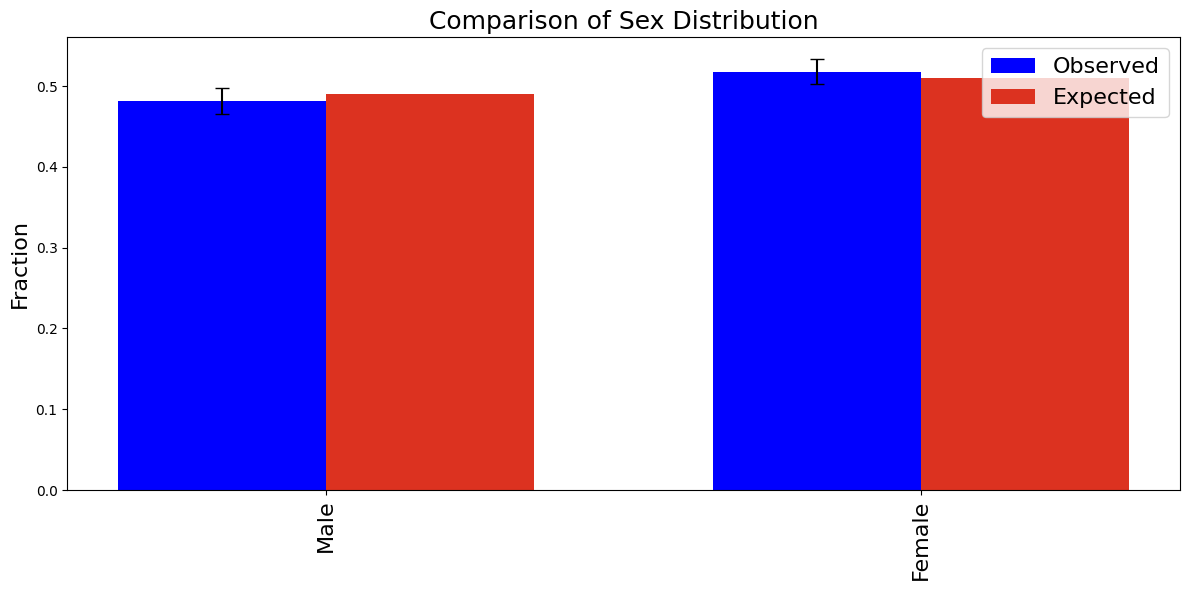

combined: [0.292   0.17995 0.152   0.23045 0.1456 ]
0.29200000000000004
var: 206.73600000000002
std: 14.378317008607093
0.17995
var: 147.5679975
std: 12.147756891706386
0.152
var: 128.896
std: 11.353237423748347
0.23045
var: 177.3427975
std: 13.317011582934063
0.1456
var: 124.40064
std: 11.153503485452452
Saved: plots/comparison_of_age_distribution_(observed_vs._expected).png


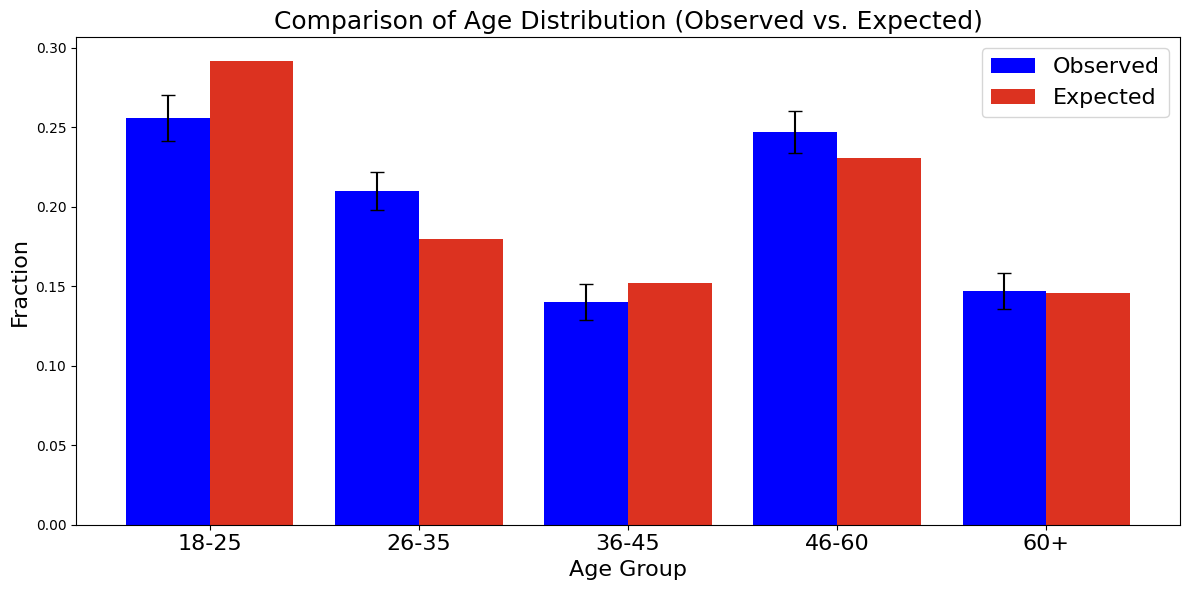

/tmp/ipykernel_929265/416342638.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y="Ethnicity_Category", palette="colorblind",


[0.069 0.034 0.347 0.228 0.149 0.069 0.032 0.015 0.032]
[0.0243 0.0334 0.4313 0.2328 0.1417 0.0763 0.0198 0.0158 0.0251]
0.0243
var: 23.709509999999998
std: 4.869241213988069
0.0334
var: 32.28444
std: 5.681939809607279
0.4313
var: 245.28031
std: 15.661427457291369
0.2328
var: 178.60416
std: 13.364286737420745
0.1417
var: 121.62111
std: 11.028196135361394
0.0763
var: 70.47831000000001
std: 8.395136091809352
0.0198
var: 19.40796
std: 4.405446628890197
0.0158
var: 15.55036
std: 3.9433944768435225
0.0251
var: 24.469990000000003
std: 4.946715071640978
[np.float64(0.004869241213988068), np.float64(0.005681939809607279), np.float64(0.01566142745729137), np.float64(0.013364286737420746), np.float64(0.011028196135361394), np.float64(0.008395136091809353), np.float64(0.004405446628890197), np.float64(0.003943394476843522), np.float64(0.004946715071640978)]
Saved: plots/comparison_of_ethnicity_distribution.png


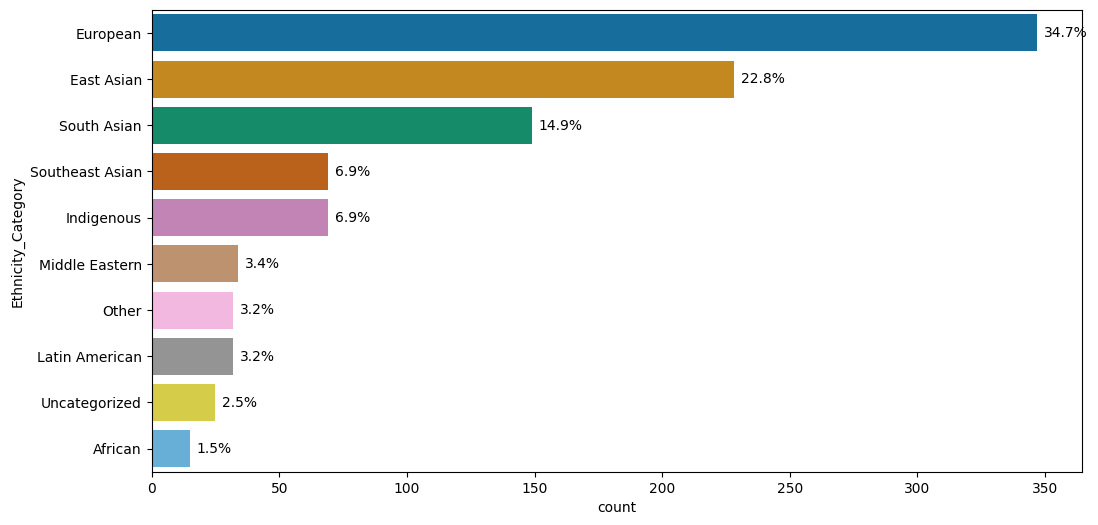

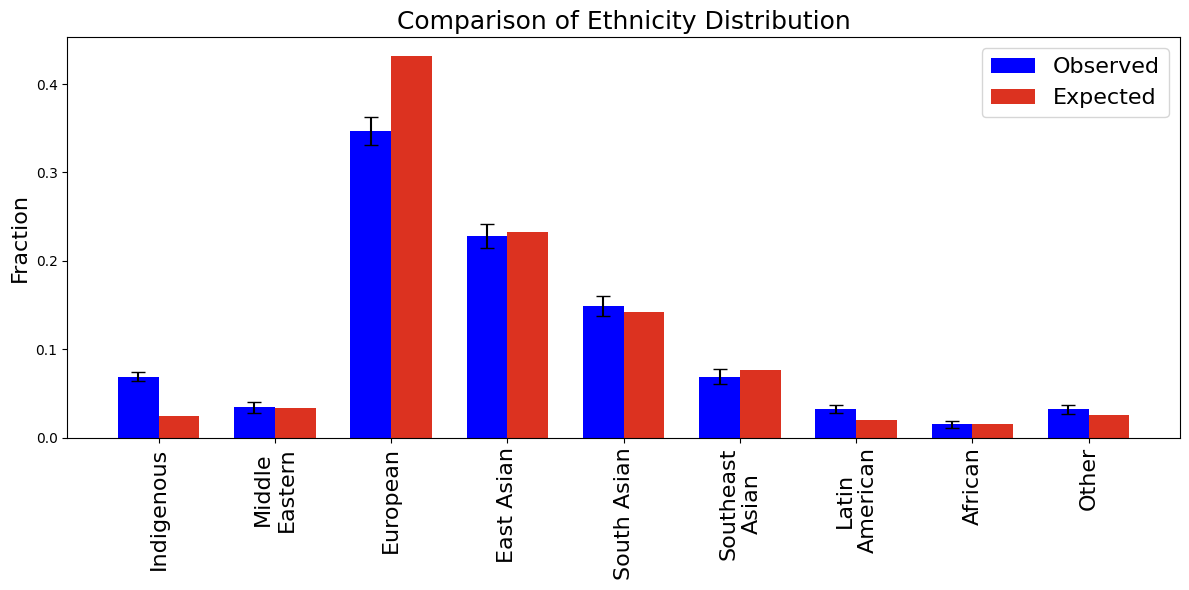

Saved: plots/combined_relationship_status.png


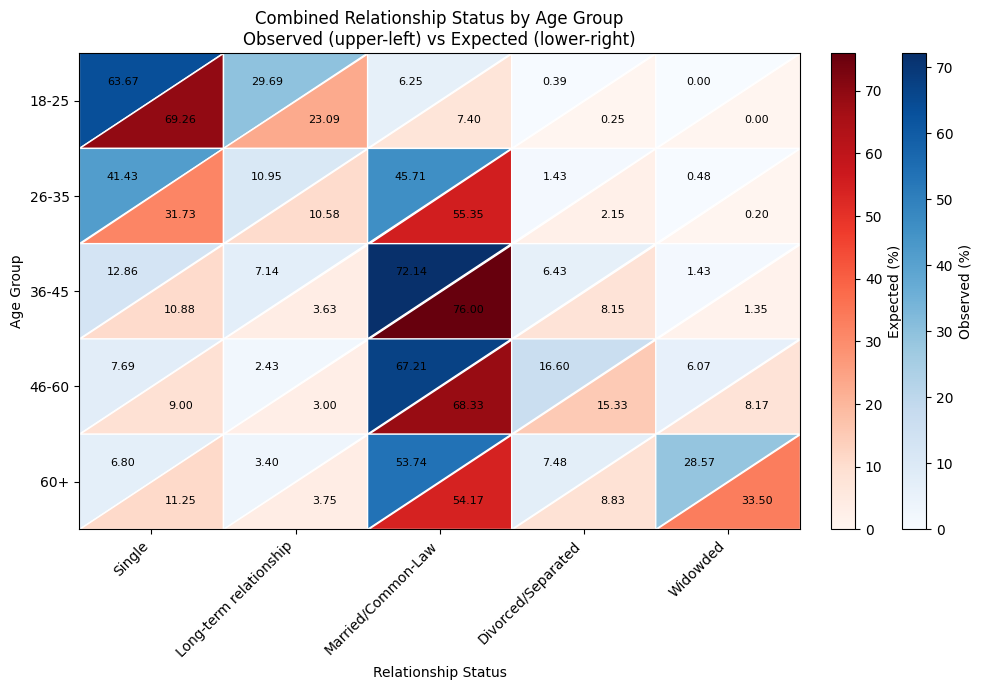

In [2]:
# =============================================================================
# Main Analysis and Plotting
# =============================================================================
def main():
    # ------------------------------
    # Load Data
    # ------------------------------
    file_path = "llm_patients_040725.csv"
    df = load_data(file_path)

    plot_children_heatmaps(df, save_fig=True)
    
    # Observed Disability Breakdown (based on your assigned categories)
    disability_categories = [
        "Mental-health related", "Pain-related", "Seeing", 
        "Learning", "Memory", "Mobility", "Flexibility", 
        "Hearing", "Dexterity", "Developmental"
    ]
    observed_counts = df['Disability'].value_counts()
    total_observed = observed_counts.sum()
    observed_data = {cat: observed_counts.get(cat, 0) / total_observed for cat in disability_categories}

    # Expected Disability Breakdown using compute_expected_disability function
    expected_disability_df = df.apply(compute_expected_disability, axis=1)
    expected_disability_avg = expected_disability_df.mean().to_dict()

    # Generate the bar chart comparing observed vs expected values
    plot_comparison(observed_data, expected_disability_avg, "Disability Breakdown: Observed vs Expected", save_fig=True)

    # ------------------------------
    # Ethnicity Distribution Analysis
    # ------------------------------
    ETHNICITY_CATEGORIES = {
        "Indigenous": ["English - Canada", "English - United States", "English - United Kingdom", "English - Ireland"],
        "Middle Eastern": ["Persian - Iran", "Hebrew - Israel"],
        "European": [
            "Czech - Czech Republic", "Danish - Denmark", "German - Austria", "German - Switzerland", "German - Germany",
            "Greek - Greece",
            "Spanish - Spain", "Finnish - Finland", "French - Canada", "French - Switzerland", "French - France",
            "Croatian - Croatia", "Hungarian - Hungary", "Armenian - Armenia", "Italian - Italy", "Dutch - Belgium",
            "Dutch - Netherlands", "Norwegian - Norway", "Polish - Poland", "Portuguese - Portugal", "Romanian - Romania",
            "Russian - Russia", "Slovak - Slovakia", "Swedish - Sweden", "Ukrainian - Ukraine"
        ],
        "East Asian": ["Japanese - Japan", "Korean - South Korea", "Chinese - China", "Chinese - Taiwan"],
        "South Asian": ["English - India", "Hindi - India", "Nepali - Nepal", "Tamil - India", "Bengali - Bangladesh",
                        "English - Bangladesh", "Georgian - Georgia", "Azerbaijani - Azerbaijan"],
        "Southeast Asian": ["English - Malaysia", "English - Philippines", "Filipino - Philippines", "Indonesian - Indonesia",
                            "Thai - Thailand", "Tagalog - Philippines", "Vietnamese - Vietnam"],
        "Latin American": ["Spanish - Argentina", "Spanish - Chile", "Spanish - Colombia", "Spanish - Mexico", "Portuguese - Brazil"],
        "African": ["Zulu - South Africa"],
        "Other": ["English - Australia", "English - New Zealand"],
    }

    def categorize_ethnicity(ethnicity):
        for category, values in ETHNICITY_CATEGORIES.items():
            if ethnicity in values:
                return category
        return "Uncategorized"

    df["Ethnicity_Category"] = df["Ethnicity"].apply(categorize_ethnicity)

    # Preprocess additional columns
    df.rename(columns={
        "Sex": "Gender",
        "Relationship Status": "Relationship_Status",
        "Children": "Has_Children",
        "Current Doctor(s)": "Has_Current_Doctor",
        "Canadian Citizenship": "Is_Canadian"
    }, inplace=True)

    # For detailed demographic comparisons, use an extended age grouping
    df['Age_Group'] = df['Age'].apply(assign_age_group_extended)
    relationship_mapping = {
        "Common-Law": "Married/Common-Law",
        "Married": "Married/Common-Law",
        "Divorced": "Divorced/Separated",
        "Separated": "Divorced/Separated"
    }
    df["Relationship_Status"] = df["Relationship_Status"].replace(relationship_mapping)
    df["Gender"] = df["Gender"].astype("category")
    df["Ethnicity_Category"] = df["Ethnicity_Category"].astype("category")
    df["Relationship_Status"] = df["Relationship_Status"].astype("category")
    df["Has_Children"] = df["Has_Children"].apply(lambda x: "Yes" if str(x).strip().lower() == "yes" else "No")
    df["Has_Current_Doctor"] = df["Has_Current_Doctor"].apply(lambda x: "Yes" if pd.notna(x) else "No")
    df["Is_Canadian"] = df["Is_Canadian"].apply(lambda x: "Yes" if str(x).strip().lower() == "yes" else "No")


    # Compare Gender Distribution with Actual Demographics
    gender_weights = [0.49, 0.51]
    gender_labels = ["Male", "Female"]
    df_gender_counts = df["Gender"].value_counts(normalize=True)
    actual_gender_dist = pd.Series(gender_weights, index=gender_labels)
    plot_comparison(df_gender_counts, actual_gender_dist, "Comparison of Sex Distribution", save_fig=True)

    # Age Distribution Comparisons
    age_labels_order = ["18-25", "26-35", "36-45", "46-60", "60+"]


    # Compute observed and actual counts
    observed_age_counts = df["Age_Group"].value_counts().reindex(age_labels_order, fill_value=0)
    observed_combined = observed_age_counts / observed_age_counts.sum()  # Convert to percentages

    # Actual age distribution (averaged for men and women)
    age_weights_men = [0.2979, 0.1916, 0.1557, 0.2266, 0.1282]
    age_weights_women = [0.2861, 0.1683, 0.1483, 0.2343, 0.1630]
    actual_combined = np.array([(m + w) / 2 for m, w in zip(age_weights_men, age_weights_women)]) # Convert to percentages
    print("combined:", actual_combined)

    sample_size = 1000
    standard_devs = []
    for i in actual_combined:
        print(i)
        variance = (sample_size * i)*(1-i)
        print("var:", variance)
        standard_dev = np.sqrt(variance)
        print("std:", standard_dev)
        standard_dev = standard_dev/1000
        standard_devs.append(standard_dev)
    
    
    # Define x-axis positions and width
    x = np.arange(len(age_labels_order))
    width = 0.4

    # Create the bar chart with observed bars on the left and expected on the right
    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width / 2, observed_combined, width, label="Observed", color="blue", yerr=standard_devs, capsize=5)
    bars2 = ax.bar(x + width / 2, actual_combined, width, label="Expected", color="#DC3220")

    # Labels and titles
    # ax.tick_params(axis='y', labelsize=font_size)
    ax.set_xticks(x)
    ax.set_xticklabels(age_labels_order, fontsize = 16)
    ax.set_xlabel("Age Group", fontsize = 16)
    ax.set_ylabel("Fraction", fontsize = 16)
    ax.set_title("Comparison of Age Distribution (Observed vs. Expected)", fontsize = 18)
    ax.legend(fontsize = 16)
    
    # Display the plot
    title = "Comparison of Age Distribution (Observed vs. Expected)"
    plt.tight_layout()
    filename = f"{output_dir}/{title.replace(' ', '_').lower()}.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Saved: {filename}")
    plt.show()

    # Ethnicity Distribution by Category
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(data=df, y="Ethnicity_Category", palette="colorblind",
                       order=df["Ethnicity_Category"].value_counts().index)
    total = len(df)
    for p in ax.patches:
        percentage = f'{100 * p.get_width() / total:.1f}%'
        ax.annotate(percentage, (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

    ethnicity_weights = [0.0243, 0.0334, 0.4313, 0.2328, 0.1417, 0.0763, 0.0198, 0.0158, 0.0251]
    ethnicity_labels = list(ETHNICITY_CATEGORIES.keys())
    df_ethnicity_counts = df["Ethnicity_Category"].value_counts(normalize=True)
    actual_ethnicity_dist = pd.Series(ethnicity_weights, index=ethnicity_labels)
    plot_comparison(df_ethnicity_counts, actual_ethnicity_dist, "Comparison of Ethnicity Distribution", save_fig=True)



    # --------------------------------------------------------------------
    # Assume these variables/dataframes are defined as in your workflow:
    # --------------------------------------------------------------------
    # Relationship ordering as used in your observed heatmap:
    relationship_order = ["Single", "Long-term relationship", "Married/Common-Law", "Divorced/Separated", "Widowded"]
    # Age group order (make sure it matches the ordering in your DataFrame and expected weights)
    age_labels_order = ["18-25", "26-35", "36-45", "46-60", "60+"]

    # --------------------------------------------------------------------
    # Observed Data: Create observed percentage DataFrame from your DataFrame 'df'
    # (Make sure df['Relationship_Status'] is set with the appropriate categorical order.)
    observed_df = pd.crosstab(df["Age_Group"], df["Relationship_Status"], normalize="index") * 100

    # Reindex to ensure both rows and columns are in the desired order.
    observed_df = observed_df.reindex(index=age_labels_order, columns=relationship_order)

    # --------------------------------------------------------------------
    # Expected Data: You already have a DataFrame for the expected/actual weights.
    # If your expected DataFrame was originally built like:
    relationship_status_labels = ["Single", "Long-term Relationship", "Married/Common-law", "Divorced/Separated", "Widowed"]
    relationship_weights = [
      [69.26, 23.09, 7.40, 0.25, 0.0],  # 18-25
      [31.73, 10.58, 55.35, 2.15, 0.20],  # 26-35
      [10.88, 3.63, 76.00, 8.15, 1.35],   # 36-45
      [9.00, 3.00, 68.33, 15.33, 8.17],    # 46-60
      [11.25, 3.75, 54.17, 8.83, 33.50]    # 60+
    ]
    relationship_weights_df = pd.DataFrame(relationship_weights, index=age_labels_order, columns=relationship_status_labels)

    # To match with the observed column labels, you might want to reindex the expected DataFrame using the same ordering.
    # Here we assume that the labels are equivalent (aside from capitalization differences). Adjust if needed.

    # For simplicity, we’ll map the expected labels to our relationship_order.
    expected_mapping = {
        "Single": "Single",
        "Long-term Relationship": "Long-term relationship",
        "Married/Common-law": "Married/Common-Law",
        "Divorced/Separated": "Divorced/Separated",
        "Widowed": "Widowded"
    }
    expected_df = relationship_weights_df.rename(columns=expected_mapping)
    expected_df = expected_df.reindex(index=age_labels_order, columns=relationship_order)

    # Convert both DataFrames to numpy arrays for ease of plotting
    observed = observed_df.values  # these are decimals between 0 and 1
    expected = expected_df.values  # these are expected percentages

    n_rows, n_cols = observed.shape

    # --------------------------------------------------------------------
    # Create color maps and normalization for each set of data.
    # Here, the observed values are in decimals and expected remain as percentages.
    cmap_obs = plt.get_cmap("Blues")
    cmap_exp = plt.get_cmap("Reds")

    norm_obs = mcolors.Normalize(vmin=np.nanmin(observed), vmax=np.nanmax(observed))
    norm_exp = mcolors.Normalize(vmin=np.nanmin(expected), vmax=np.nanmax(expected))

    # Create the figure and axis.
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_xlim(0, n_cols)
    ax.set_ylim(0, n_rows)
    ax.invert_yaxis()  # so that row 0 appears at the top

    # Set tick labels (centered in each cell).
    ax.set_xticks(np.arange(n_cols) + 0.5)
    ax.set_yticks(np.arange(n_rows) + 0.5)
    ax.set_xticklabels(relationship_order, rotation=45, ha="right")
    ax.set_yticklabels(age_labels_order)

    # --------------------------------------------------------------------
    # Draw each cell by splitting it into two diagonal triangles.
    for i in range(n_rows):
        for j in range(n_cols):
            # Coordinates for the cell boundaries (each cell is 1x1):
            x_left, y_top = j, i
            tl = (x_left, y_top)             # top-left
            bl = (x_left, y_top + 1)           # bottom-left
            br = (x_left + 1, y_top + 1)       # bottom-right
            tr = (x_left + 1, y_top)           # top-right

            # --- Observed Data (upper-left triangle) ---
            color_obs = cmap_obs(norm_obs(observed[i, j]))
            triangle_obs = patches.Polygon([tl, bl, tr], facecolor=color_obs, edgecolor="white")
            ax.add_patch(triangle_obs)

            # --- Expected Data (lower-right triangle) ---
            color_exp = cmap_exp(norm_exp(expected[i, j]))
            triangle_exp = patches.Polygon([bl, br, tr], facecolor=color_exp, edgecolor="white")
            ax.add_patch(triangle_exp)

            # Add observed annotation:
            # Place roughly at 30% from the left and 30% from the top of the cell.
            obs_text_x = x_left + 0.3
            obs_text_y = y_top + 0.3
            # Format as two-decimal floats (observed values are decimals)
            ax.text(obs_text_x, obs_text_y, f"{observed[i, j]:.2f}", ha="center", va="center",
                    fontsize=8, color="black")

            # Add expected annotation:
            # Place roughly at 70% from the left and 70% from the top of the cell.
            exp_text_x = x_left + 0.7
            exp_text_y = y_top + 0.7
            ax.text(exp_text_x, exp_text_y, f"{expected[i, j]:.2f}", ha="center", va="center",
                    fontsize=8, color="black")

    # Set title and axis labels.
    ax.set_title("Combined Relationship Status by Age Group\nObserved (upper-left) vs Expected (lower-right)")
    ax.set_xlabel("Relationship Status")
    ax.set_ylabel("Age Group")

    # Optionally, add colorbars for each data set.
    sm_obs = plt.cm.ScalarMappable(cmap=cmap_obs, norm=norm_obs)
    sm_obs.set_array([])
    cbar_obs = fig.colorbar(sm_obs, ax=ax, fraction=0.046, pad=0.04)
    cbar_obs.set_label("Observed (%)")

    sm_exp = plt.cm.ScalarMappable(cmap=cmap_exp, norm=norm_exp)
    sm_exp.set_array([])
    cbar_exp = fig.colorbar(sm_exp, ax=ax, fraction=0.046, pad=0.04)
    cbar_exp.set_label("Expected (%)")

    plt.tight_layout()

    # Save the combined plot if desired.
    filename = "plots/combined_relationship_status.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Saved: {filename}")

    plt.show()
 
if __name__ == "__main__":
    main()